# Blue Bikes Data Processing

This notebook processes raw Blue Bikes trip data, weather data, and calendar features into a single merged dataset for modeling.

## Steps:
1. Load and aggregate trip data to daily counts per station
2. Load and clean weather data
3. Load calendar features (holidays and academic breaks)
4. Merge all datasets
5. Add temporal features
6. Handle missing values
7. Save processed data

---


## 1. Setup and Imports

In [44]:
import pandas as pd
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Trip Data

Loading all monthly trip CSV files and aggregating to daily trip counts per station.

In [45]:
# Find all trip files
trip_files = glob('../data/raw/trips/**/*.csv', recursive=True)
print(f"Found {len(trip_files)} trip files")
print(f"\nFirst few files:")
for f in trip_files[:3]:
    print(f"  - {f}")

Found 45 trip files

First few files:
  - ../data/raw/trips\2022\202201-bluebikes-tripdata.csv
  - ../data/raw/trips\2022\202202-bluebikes-tripdata.csv
  - ../data/raw/trips\2022\202203-bluebikes-tripdata.csv


### 2.1 Handle CSV Format Change

**Note:** Blue Bikes changed their CSV format in April 2023:

**Old format (before 2023-04):**
- Columns: `starttime`, `stoptime`, `start station id`, `start station name`, `usertype`
- Example: `"2023-03-01 00:00:44.1520"`

**New format (2023-04 onwards):**
- Columns: `started_at`, `ended_at`, `start_station_id`, `start_station_name`, `member_casual`
- Example: `"2023-04-13 13:49:59"`

The loading code below detects which format each file uses and standardizes column names to the new format for consistency.

In [46]:
# Load all trip data
all_trips = []

for i, file in enumerate(trip_files):
    if i % 5 == 0:  # Print progress every 5 files
        print(f"Processing {i+1}/{len(trip_files)}...")
    
    try:
        df = pd.read_csv(file)
        
        # Check which format this file uses and standardize column names
        if 'starttime' in df.columns:
            # Old format (before 2023-04)
            df = df.rename(columns={
                'starttime': 'started_at',
                'stoptime': 'ended_at',
                'start station id': 'start_station_id',
                'start station name': 'start_station_name',
                'start station latitude': 'start_lat',    
                'start station longitude': 'start_lng',
                'usertype': 'member_casual'
            })
        elif 'started_at' in df.columns:
            # New format (2023-04 onwards)
            # Columns already in correct format
            pass
        
        all_trips.append(df)
        
    except Exception as e:
        print(f"Error reading {file}: {e}")
        continue

print("Concatenating all trips...")
trips = pd.concat(all_trips, ignore_index=True)
print(f"✓ Total trips loaded: {len(trips):,}")

Processing 1/45...
Processing 6/45...
Processing 11/45...
Processing 16/45...
Processing 21/45...
Processing 26/45...
Processing 31/45...
Processing 36/45...
Processing 41/45...
Concatenating all trips...
✓ Total trips loaded: 15,770,376


### 2.2 Standardize Station IDs

**Issue discovered:** In addition to the CSV format change, Blue Bikes also changed their station ID format:
- **Old format:** Numeric IDs (e.g., `67`, `143`, `486`)
- **New format:** Alphanumeric IDs (e.g., `M32006`, `D32016`, `N32008`)

The same physical station location has different IDs in the two periods, causing duplicates when counting unique stations. For example:
- Historic ID `486` and new ID `N32008` are both "Union St at Herrick Rd"
- Historic ID `67` and new ID `M32006` are both "MIT at Mass Ave / Amherst St"

**Solution:** Use the official Blue Bikes station list, which includes a "Station ID (to match to historic system data)" column that maps old IDs to new IDs. This ensures each physical location is counted only once.

**Note:** Stations added after March 2023 only have alphanumeric IDs and are unaffected by this mapping. Stations that closed before March 2023 retain their historic numeric IDs.

In [47]:
# Load official station list (auto-detect CSV in stations folder)
from glob import glob

station_files = glob('../data/raw/stations/*.csv')
if len(station_files) == 0:
    raise FileNotFoundError("No CSV file found in data/raw/stations/. Please download the Blue Bikes station list.")
elif len(station_files) > 1:
    print(f"Warning: Multiple CSV files found in stations folder. Using: {station_files[0]}")

station_file = station_files[0]
print(f"Loading station list from: {station_file}")

# Load with skiprows=1 to skip metadata row
official_stations = pd.read_csv(station_file, skiprows=1)

print(f"Official station list loaded: {len(official_stations)} stations")
print("\nColumns:")
print(official_stations.columns.tolist())
print("\nSample stations:")
print(official_stations.head())

# Create mapping from historic ID to new ID
id_mapping = official_stations[['Station ID (to match to historic system data)', 'Number']].copy()
id_mapping.columns = ['old_id', 'new_id']

# Remove rows where historic ID is missing or contains "No ID"
id_mapping = id_mapping[id_mapping['old_id'].notna()]
id_mapping = id_mapping[~id_mapping['old_id'].astype(str).str.contains('No ID', na=False)]

# Convert to dictionary for mapping
id_conversion = dict(zip(id_mapping['old_id'].astype(str), id_mapping['new_id'].astype(str)))

print(f"\n✓ Created mapping for {len(id_conversion)} historic station IDs")
print("\nSample mappings:")
for i, (old, new) in enumerate(id_conversion.items()):
    if i < 10:  # Show first 10
        station_name = official_stations[official_stations['Number'] == new]['NAME'].values
        station_name = station_name[0] if len(station_name) > 0 else "Unknown"
        print(f"  {old} → {new} ({station_name})")

# Apply mapping to convert old IDs to new format
trips['start_station_id'] = trips['start_station_id'].astype(str).replace(id_conversion)

print(f"\n✓ Station IDs standardized using official mapping")
print(f"Unique stations after mapping: {trips['start_station_id'].nunique()}")

Loading station list from: ../data/raw/stations\-External-_Bluebikes_Station_List - current_bluebikes_stations (2).csv
Official station list loaded: 572 stations

Columns:
['Number', 'NAME', 'Lat', 'Long', 'Seasonal Status', 'Municipality', 'Total Docks', 'Station ID (to match to historic system data)']

Sample stations:
   Number                                  NAME        Lat       Long  \
0  L32001    Railroad Lot and Minuteman Bikeway  42.416065 -71.153366   
1  L32002       Linwood St at Minuteman Bikeway  42.409354 -71.149065   
2  L32005  Thorndike Field at Minuteman Bikeway  42.400168 -71.144570   
3  L32003                Mass Ave at Grafton St  42.407261 -71.143821   
4  L32004                Broadway at Grafton St  42.409942 -71.140093   

  Seasonal Status Municipality  Total Docks  \
0      Year Round    Arlington           11   
1      Year Round    Arlington           11   
2      Year Round    Arlington           11   
3      Year Round    Arlington           11   
4  

In [48]:
# Examine trip data structure
print("Trip data columns:")
print(trips.columns.tolist())
print(f"\nTrip data shape: {trips.shape}")
print("\nFirst few rows:")
trips.head()

Trip data columns:
['tripduration', 'started_at', 'ended_at', 'start_station_id', 'start_station_name', 'start_lat', 'start_lng', 'end station id', 'end station name', 'end station latitude', 'end station longitude', 'bikeid', 'member_casual', 'postal code', 'ride_id', 'rideable_type', 'end_station_name', 'end_station_id', 'end_lat', 'end_lng']

Trip data shape: (15770376, 20)

First few rows:


,tripduration,started_at,ended_at,start_station_id,start_station_name,start_lat,start_lng,end station id,end station name,end station latitude,end station longitude,bikeid,member_casual,postal code,ride_id,rideable_type,end_station_name,end_station_id,end_lat,end_lng
0,597.0,2022-01-01 00:00:25.1660,2022-01-01 00:10:22.1920,M32041,MIT Pacific St at Purrington St,42.359573,-71.101295,74.0,Harvard Square at Mass Ave/ Dunster,42.373268,-71.118579,4923.0,Subscriber,02139,NaN,NaN,NaN,NaN,NaN,NaN
1,411.0,2022-01-01 00:00:40.4300,2022-01-01 00:07:32.1980,M32004,Kendall T,42.362428,-71.084955,178.0,MIT Pacific St at Purrington St,42.359573,-71.101295,3112.0,Subscriber,02139,NaN,NaN,NaN,NaN,NaN,NaN
2,476.0,2022-01-01 00:00:54.8180,2022-01-01 00:08:51.6680,D32020,Main St at Austin St,42.375603,-71.064608,356.0,Charlestown Navy Yard,42.374125,-71.054812,6901.0,Customer,02124,NaN,NaN,NaN,NaN,NaN,NaN
3,466.0,2022-01-01 00:01:01.6080,2022-01-01 00:08:48.2350,D32020,Main St at Austin St,42.375603,-71.064608,356.0,Charlestown Navy Yard,42.374125,-71.054812,5214.0,Customer,02124,NaN,NaN,NaN,NaN,NaN,NaN
4,752.0,2022-01-01 00:01:06.0520,2022-01-01 00:13:38.2300,A32008,Park Dr at Buswell St,42.347241,-71.105301,41.0,Packard's Corner - Commonwealth Ave at Brighto...,42.352261,-71.123831,2214.0,Subscriber,02215,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Clean column names (remove any quotes or extra spaces)
trips.columns = trips.columns.str.strip().str.replace('"', '')

# Convert timestamps to datetime (mixed format to handle both old and new CSV formats)
print("Converting timestamps...")
trips['started_at'] = pd.to_datetime(trips['started_at'], format='mixed')
trips['ended_at'] = pd.to_datetime(trips['ended_at'], format='mixed')

# Extract date
trips['date'] = trips['started_at'].dt.date

print("✓ Timestamps converted and date extracted")
print(f"Date range: {trips['date'].min()} to {trips['date'].max()}")

Converting timestamps...
✓ Timestamps converted and date extracted
Date range: 2022-01-01 to 2025-09-30


In [50]:
# Aggregate to daily counts per station, keeping coordinates
print("Aggregating to daily counts per station...")

# Get trip counts
daily_counts = trips.groupby(['start_station_id', 'start_station_name', 'date']).size().reset_index(name='trip_count')

# Get coordinates (first occurrence for each station)
coords = trips.groupby('start_station_id')[['start_lat', 'start_lng']].first().reset_index()

# Merge coordinates with daily counts
daily_counts = daily_counts.merge(coords, on='start_station_id', how='left')

print(f"Initial daily station records: {len(daily_counts):,}")

# Consolidate stations with duplicate names
print("\nConsolidating stations with duplicate names...")

# For each unique station name, pick one preferred ID
name_to_preferred_id = {}
for name in daily_counts['start_station_name'].unique():
    # Get all IDs for this station name
    ids_for_name = daily_counts[daily_counts['start_station_name'] == name]['start_station_id'].unique()
    
    # Prefer alphanumeric IDs
    alphanumeric = [id for id in ids_for_name if not str(id).isdigit()]
    preferred = alphanumeric[0] if alphanumeric else ids_for_name[0]
    
    name_to_preferred_id[name] = preferred

# Map all station IDs to their preferred version based on name
daily_counts['station_id'] = daily_counts['start_station_name'].map(name_to_preferred_id)

# Re-aggregate after consolidation, keeping coordinates
daily_counts = daily_counts.groupby(['station_id', 'start_station_name', 'date']).agg({
    'trip_count': 'sum',
    'start_lat': 'first',   # Keep lat
    'start_lng': 'first'    # Keep lng
}).reset_index()

# Rename lat/lng columns for clarity
daily_counts = daily_counts.rename(columns={'start_lat': 'lat', 'start_lng': 'lng'})

print(f"✓ After consolidation: {len(daily_counts):,} records")
print(f"✓ Unique stations: {daily_counts['station_id'].nunique()}")
print(f"✓ Date range: {daily_counts['date'].min()} to {daily_counts['date'].max()}")

Aggregating to daily counts per station...
Initial daily station records: 566,624

Consolidating stations with duplicate names...
✓ After consolidation: 566,622 records
✓ Unique stations: 608
✓ Date range: 2022-01-01 to 2025-09-30


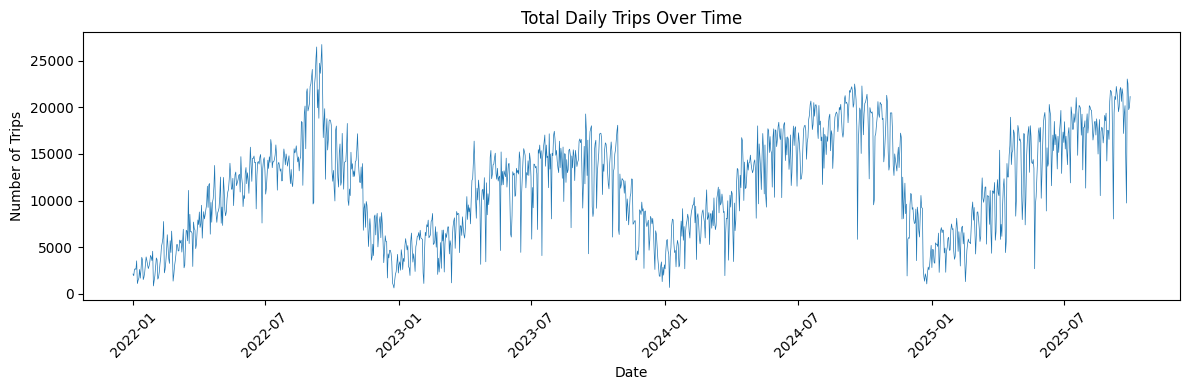

Average daily trips across all stations: 11526


In [51]:
# Quick visualization of trip data
daily_total = daily_counts.groupby('date')['trip_count'].sum()

plt.figure(figsize=(12, 4))
plt.plot(daily_total.index, daily_total.values, linewidth=0.5)
plt.title('Total Daily Trips Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Average daily trips across all stations: {daily_total.mean():.0f}")

In [52]:
# Get unique station info from processed daily_counts (after consolidation)
unique_stations = daily_counts.groupby('station_id').agg({
    'start_station_name': 'first',
    'date': ['min', 'max']
}).reset_index()

# Flatten column names
unique_stations.columns = ['station_id', 'station_name', 'first_seen', 'last_seen']

# Count total trips per station
trip_totals = daily_counts.groupby('station_id')['trip_count'].sum().reset_index()
trip_totals.columns = ['station_id', 'total_trips']

# Merge trip counts
unique_stations = unique_stations.merge(trip_totals, on='station_id', how='left')

# Reorder columns for readability
unique_stations = unique_stations[['station_id', 'station_name', 'total_trips', 'first_seen', 'last_seen']]

# Sort by total trips descending
unique_stations = unique_stations.sort_values('total_trips', ascending=False)

# Save to CSV
unique_stations.to_csv('../data/processed/unique_stations_from_trips.csv', index=False)

print(f"✓ Exported {len(unique_stations)} unique stations with names")
print(f"\nTop 10 busiest stations:")
print(unique_stations.head(10))
print(f"\nBottom 10 stations (least trips):")
print(unique_stations.tail(10))

✓ Exported 608 unique stations with names

Top 10 busiest stations:
    station_id                                       station_name  \
403     M32006                       MIT at Mass Ave / Amherst St   
406     M32011              Central Square at Mass Ave / Essex St   
413     M32018                Harvard Square at Mass Ave/ Dunster   
436     M32041                    MIT Pacific St at Purrington St   
437     M32042                                      MIT Vassar St   
264     D32016        Charles Circle - Charles St at Cambridge St   
432     M32037                                 Ames St at Main St   
74      B32005  Christian Science Plaza - Massachusetts Ave at...   
85      B32016                     Beacon St at Massachusetts Ave   
8       A32002                    Commonwealth Ave at Agganis Way   

     total_trips  first_seen   last_seen  
403       313280  2022-01-01  2025-09-30  
406       244774  2022-01-01  2025-09-30  
413       219286  2022-01-01  2025-09-30  


## 3. Load Weather Data

Loading daily weather data from Open-Meteo including temperature, precipitation, wind speed, and snowfall.

In [53]:
# Load weather data (auto-detect CSV in weather folder)
from glob import glob

weather_files = glob('../data/raw/weather/*.csv')
if len(weather_files) == 0:
    raise FileNotFoundError("No CSV file found in data/raw/weather/. Please download weather data.")
elif len(weather_files) > 1:
    print(f"Warning: Multiple CSV files found in weather folder. Using: {weather_files[0]}")

weather_file = weather_files[0]
print(f"Loading weather data from: {weather_file}")

# Load with skiprows=3 to skip all metadata rows
weather = pd.read_csv(weather_file, skiprows=3)

print(f"Weather records loaded: {len(weather)}")
print("\nWeather columns:")
print(weather.columns.tolist())
print("\nFirst few rows:")
weather.head()

Loading weather data from: ../data/raw/weather\open-meteo-42.36N71.13W19m (2).csv
Weather records loaded: 1369

Weather columns:
['time', 'temperature_2m_mean (°C)', 'wind_speed_10m_max (km/h)', 'wind_gusts_10m_max (km/h)', 'rain_sum (mm)', 'snowfall_sum (cm)', 'precipitation_sum (mm)', 'temperature_2m_min (°C)', 'temperature_2m_max (°C)', 'weather_code (wmo code)']

First few rows:


,time,temperature_2m_mean (°C),wind_speed_10m_max (km/h),wind_gusts_10m_max (km/h),rain_sum (mm),snowfall_sum (cm),precipitation_sum (mm),temperature_2m_min (°C),temperature_2m_max (°C),weather_code (wmo code)
0,2022-01-01,8.2,10.2,16.6,2.2,0.0,2.2,5.2,11.2,53
1,2022-01-02,6.0,23.2,39.6,6.2,0.0,6.2,0.4,7.9,61
2,2022-01-03,-4.0,22.3,38.5,0.0,0.0,0.0,-5.8,-1.0,3
3,2022-01-04,-5.3,18.4,34.9,0.0,0.0,0.0,-9.8,0.1,3
4,2022-01-05,3.1,26.4,53.3,6.4,0.0,6.4,-4.5,8.8,63


In [54]:
# Clean column names (remove units in parentheses)
weather.columns = weather.columns.str.strip().str.split(' ').str[0]

# Rename for clarity
weather = weather.rename(columns={
    'time': 'date',
    'temperature_2m_max': 'temp_max',
    'temperature_2m_min': 'temp_min',
    'temperature_2m_mean': 'temp_mean',
    'wind_speed_10m_max': 'wind_speed',
    'precipitation_sum': 'precipitation',
    'snowfall_sum': 'snowfall'
})

# Keep only essential columns
weather = weather[['date', 'temp_mean', 'precipitation', 'wind_speed', 'snowfall']]

# Convert date
weather['date'] = pd.to_datetime(weather['date']).dt.date

print(f"✓ Weather date range: {weather['date'].min()} to {weather['date'].max()}")
weather.head()

✓ Weather date range: 2022-01-01 to 2025-09-30


,date,temp_mean,precipitation,wind_speed,snowfall
0,2022-01-01,8.2,2.2,10.2,0.0
1,2022-01-02,6.0,6.2,23.2,0.0
2,2022-01-03,-4.0,0.0,22.3,0.0
3,2022-01-04,-5.3,0.0,18.4,0.0
4,2022-01-05,3.1,6.4,26.4,0.0


In [55]:
# Quick weather statistics
print("Weather Summary:")
print(f"  Temperature range: {weather['temp_mean'].min():.1f}°C to {weather['temp_mean'].max():.1f}°C")
print(f"  Days with precipitation: {(weather['precipitation'] > 0).sum()}")
print(f"  Days with snow: {(weather['snowfall'] > 0).sum()}")
print(f"  Max wind speed: {weather['wind_speed'].max():.1f} km/h")

Weather Summary:
  Temperature range: -16.7°C to 32.6°C
  Days with precipitation: 706
  Days with snow: 120
  Max wind speed: 54.0 km/h


## 4. Load Calendar Features

Loading calendar data including federal holidays and BU academic break periods.

In [56]:
# Load calendar features
calendar = pd.read_csv('../data/raw/dates/calendar_features.csv')

print(f"Calendar records loaded: {len(calendar)}")
print("\nCalendar columns:")
print(calendar.columns.tolist())

# Convert date
calendar['date'] = pd.to_datetime(calendar['date']).dt.date

print(f"\n✓ Federal holidays: {calendar['is_holiday'].sum()}")
print(f"✓ Academic break days: {calendar['is_academic_break'].sum()}")

calendar.head(10)

Calendar records loaded: 1461

Calendar columns:
['date', 'is_holiday', 'day_of_week', 'is_academic_break']

✓ Federal holidays: 48
✓ Academic break days: 599


,date,is_holiday,day_of_week,is_academic_break
0,2022-01-01,1,5,1
1,2022-01-02,0,6,1
2,2022-01-03,0,0,1
3,2022-01-04,0,1,1
4,2022-01-05,0,2,1
5,2022-01-06,0,3,1
6,2022-01-07,0,4,1
7,2022-01-08,0,5,1
8,2022-01-09,0,6,1
9,2022-01-10,0,0,1


## 5. Merge All Datasets

Combining trip counts, weather data, and calendar features into a single dataset.

In [57]:
# Start with daily trip counts
df = daily_counts.copy()
print(f"Starting with trip data: {len(df)} rows")

# Merge weather
df = df.merge(weather, on='date', how='left')
print(f"After weather merge: {len(df)} rows")

# Merge calendar
df = df.merge(calendar, on='date', how='left')
print(f"After calendar merge: {len(df)} rows")

print("\n✓ All datasets merged successfully")

Starting with trip data: 566622 rows
After weather merge: 566622 rows
After calendar merge: 566622 rows

✓ All datasets merged successfully


In [58]:
# Check merged data
print("Merged dataset columns:")
print(df.columns.tolist())
print(f"\nMerged dataset shape: {df.shape}")
print("\nFirst few rows:")
df.head()

Merged dataset columns:
['station_id', 'start_station_name', 'date', 'trip_count', 'lat', 'lng', 'temp_mean', 'precipitation', 'wind_speed', 'snowfall', 'is_holiday', 'day_of_week', 'is_academic_break']

Merged dataset shape: (566622, 13)

First few rows:


,station_id,start_station_name,date,trip_count,lat,lng,temp_mean,precipitation,wind_speed,snowfall,is_holiday,day_of_week,is_academic_break
0,351,Faneuil St at Arlington St,2022-01-01,1,42.352766,-71.159885,8.2,2.2,10.2,0.0,1,5,1
1,351,Faneuil St at Arlington St,2022-01-02,1,42.352766,-71.159885,6.0,6.2,23.2,0.0,0,6,1
2,351,Faneuil St at Arlington St,2022-01-03,1,42.352766,-71.159885,-4.0,0.0,22.3,0.0,0,0,1
3,351,Faneuil St at Arlington St,2022-01-05,2,42.352766,-71.159885,3.1,6.4,26.4,0.0,0,2,1
4,351,Faneuil St at Arlington St,2022-01-06,1,42.352766,-71.159885,1.4,0.0,22.4,0.0,0,3,1


## 6. Add Temporal Features

Creating additional features from date information: weekend indicator, month, and year.

In [59]:
# Convert date back to datetime for feature extraction
df['date'] = pd.to_datetime(df['date'])

# Add month and year
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

print("✓ Temporal features added: month, year")

✓ Temporal features added: month, year


## 7. Check or Fill Missing Values

Checking for and filling any missing values in the dataset.

In [60]:
# Check for missing values
print("Missing values per column:")
missing = df.isnull().sum()
print(missing)

if missing.sum() == 0:
    print("\n✓ No missing values found - data is clean!")
else:
    print(f"\n⚠ Found {missing.sum()} missing values")
    
    # Drop rows with missing weather data (can't train on incomplete data)
    weather_cols = ['temp_mean', 'precipitation', 'wind_speed', 'snowfall']
    rows_before = len(df)
    df = df.dropna(subset=weather_cols)
    rows_after = len(df)
    
    if rows_before > rows_after:
        print(f"✓ Dropped {rows_before - rows_after} rows with missing weather data")
    
    # Fill missing calendar values with 0 (assume not holiday/break if missing)
    df['is_holiday'] = df['is_holiday'].fillna(0).astype(int)
    df['is_academic_break'] = df['is_academic_break'].fillna(0).astype(int)
    
    print("✓ Missing values handled")

Missing values per column:
station_id            0
start_station_name    0
date                  0
trip_count            0
lat                   0
lng                   0
temp_mean             0
precipitation         0
wind_speed            0
snowfall              0
is_holiday            0
day_of_week           0
is_academic_break     0
month                 0
year                  0
dtype: int64

✓ No missing values found - data is clean!


## 8. Final Dataset Summary

Summary statistics and overview of the processed dataset.

In [61]:
print("=" * 60)
print("FINAL PROCESSED DATASET SUMMARY")
print("=" * 60)

print(f"\nDataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Number of unique stations: {df['station_id'].nunique()}")
print(f"Total trips recorded: {df['trip_count'].sum():,}")

print(f"\n📊 Trip Statistics:")
print(f"  Average trips per station per day: {df['trip_count'].mean():.2f}")
print(f"  Median trips per station per day: {df['trip_count'].median():.2f}")
print(f"  Max trips per station per day: {df['trip_count'].max()}")
print(f"  Min trips per station per day: {df['trip_count'].min()}")

print(f"\n🌡️ Weather Statistics:")
print(f"  Temperature range: {df['temp_mean'].min():.1f}°C to {df['temp_mean'].max():.1f}°C")
# Count unique dates, not rows
unique_dates = df.groupby('date').first()
print(f"  Days with precipitation: {(unique_dates['precipitation'] > 0).sum()}")
print(f"  Days with snow: {(unique_dates['snowfall'] > 0).sum()}")

print(f"\n📅 Calendar Statistics:")
print(f"  Unique dates: {df['date'].nunique()}")
print(f"  Holiday days: {(unique_dates['is_holiday'] == 1).sum()}")
print(f"  Academic break days: {(unique_dates['is_academic_break'] == 1).sum()}")

print(f"\n📂 Final columns: {list(df.columns)}")

FINAL PROCESSED DATASET SUMMARY

Dataset shape: (566622, 15)
Date range: 2022-01-01 00:00:00 to 2025-09-30 00:00:00
Number of unique stations: 608
Total trips recorded: 15,767,696

📊 Trip Statistics:
  Average trips per station per day: 27.83
  Median trips per station per day: 16.00
  Max trips per station per day: 694
  Min trips per station per day: 1

🌡️ Weather Statistics:
  Temperature range: -16.7°C to 32.6°C
  Days with precipitation: 706
  Days with snow: 120

📅 Calendar Statistics:
  Unique dates: 1368
  Holiday days: 44
  Academic break days: 599

📂 Final columns: ['station_id', 'start_station_name', 'date', 'trip_count', 'lat', 'lng', 'temp_mean', 'precipitation', 'wind_speed', 'snowfall', 'is_holiday', 'day_of_week', 'is_academic_break', 'month', 'year']


In [62]:
# Display summary statistics
df.describe()

,date,trip_count,lat,lng,temp_mean,precipitation,wind_speed,snowfall,is_holiday,day_of_week,is_academic_break,month,year
count,566622,566622.000000,566622.000000,566622.000000,566622.000000,566622.000000,566622.000000,566622.00000,566622.000000,566622.000000,566622.000000,566622.000000,566622.000000
mean,2024-01-06 21:25:34.394358272,27.827539,42.359848,-71.088081,12.439384,3.057558,19.602021,0.13774,0.030279,2.988428,0.455923,6.414139,2023.525608
min,2022-01-01 00:00:00,1.000000,42.167226,-71.247759,-16.700000,0.000000,6.900000,0.00000,0.000000,0.000000,0.000000,1.000000,2022.000000
25%,2023-02-02 00:00:00,5.000000,42.340122,-71.116267,4.900000,0.000000,15.200000,0.00000,0.000000,1.000000,0.000000,4.000000,2023.000000
50%,2024-02-01 00:00:00,16.000000,42.359825,-71.088220,13.700000,0.100000,18.600000,0.00000,0.000000,3.000000,0.000000,6.000000,2024.000000
75%,2024-12-13 00:00:00,38.000000,42.379160,-71.063738,20.100000,2.200000,23.200000,0.00000,0.000000,5.000000,1.000000,9.000000,2024.000000
max,2025-09-30 00:00:00,694.000000,42.534669,-70.870214,32.600000,69.800000,54.000000,26.81000,1.000000,6.000000,1.000000,12.000000,2025.000000
std,NaN,34.789571,0.038914,0.047241,9.320726,7.254393,6.223188,1.05468,0.171355,1.996687,0.498054,3.194014,1.089902


In [63]:
# Sample of the data
df.head(20)

,station_id,start_station_name,date,trip_count,lat,lng,temp_mean,precipitation,wind_speed,snowfall,is_holiday,day_of_week,is_academic_break,month,year
0,351,Faneuil St at Arlington St,2022-01-01,1,42.352766,-71.159885,8.2,2.2,10.2,0.00,1,5,1,1,2022
1,351,Faneuil St at Arlington St,2022-01-02,1,42.352766,-71.159885,6.0,6.2,23.2,0.00,0,6,1,1,2022
2,351,Faneuil St at Arlington St,2022-01-03,1,42.352766,-71.159885,-4.0,0.0,22.3,0.00,0,0,1,1,2022
3,351,Faneuil St at Arlington St,2022-01-05,2,42.352766,-71.159885,3.1,6.4,26.4,0.00,0,2,1,1,2022
4,351,Faneuil St at Arlington St,2022-01-06,1,42.352766,-71.159885,1.4,0.0,22.4,0.00,0,3,1,1,2022
5,351,Faneuil St at Arlington St,2022-01-07,1,42.352766,-71.159885,-2.0,13.7,26.5,9.59,0,4,1,1,2022
6,351,Faneuil St at Arlington St,2022-01-08,2,42.352766,-71.159885,-7.7,0.0,17.6,0.00,0,5,1,1,2022
7,351,Faneuil St at Arlington St,2022-01-09,1,42.352766,-71.159885,-0.4,2.9,30.5,0.00,0,6,1,1,2022
8,351,Faneuil St at Arlington St,2022-01-10,1,42.352766,-71.159885,-2.3,0.0,21.7,0.00,0,0,1,1,2022
9,351,Faneuil St at Arlington St,2022-01-11,1,42.352766,-71.159885,-10.6,0.1,25.9,0.07,0,1,1,1,2022


## 9. Save Processed Data

Saving the final merged dataset for use in modeling.

In [64]:
# Save full dataset
output_path = '../data/processed/merged_data.csv'
df.to_csv(output_path, index=False)
print(f"✓ Saved full dataset: {len(df)} rows")
print(f"  Location: {output_path}")

# Save sample for GitHub
sample_path = '../data/processed/sample_merged_data.csv'
df.head(1000).to_csv(sample_path, index=False)
print(f"✓ Saved sample dataset: 1000 rows")
print(f"  Location: {sample_path}")

print("\n✅ Data processing complete!")

✓ Saved full dataset: 566622 rows
  Location: ../data/processed/merged_data.csv
✓ Saved sample dataset: 1000 rows
  Location: ../data/processed/sample_merged_data.csv

✅ Data processing complete!


---

## Next Steps

The processed dataset (`merged_data.csv`) is now ready for analysis and modeling.

**The next notebook (`02_visualisations_and_feature_extraction.ipynb`) details my feature extraction and selection process**, including:

- **Why I chose these specific base features** (weather, temporal, calendar, location)
- **Correlational analysis** that I used to extract these features, showing each feature's relationship with trip demand
- **Visual evidence** through exploratory data analysis to support feature selection decisions

This notebook implemented the features; the next notebook explains and justifies those choices systematically.